In [3]:
import sys,os,imageio,lpips
root = '/home/youngsun/documents/mvs/mvsnerf_timing'
os.chdir(root)
sys.path.append(root)

from opt import config_parser
from data import dataset_dict
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# models
from models_timer import *
from renderer_timer import *
from data.ray_utils import get_rays

from tqdm import tqdm


from skimage.metrics import structural_similarity

# pytorch-lightning
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import LightningModule, Trainer, loggers


from data.ray_utils import ray_marcher

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

torch.cuda.set_device(0)
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def decode_batch(batch):
    rays = batch['rays']  # (B, 8)
    rgbs = batch['rgbs']  # (B, 3)
    return rays, rgbs

def unpreprocess(data, shape=(1,1,3,1,1)):
    # to unnormalize image for visualization
    # data N V C H W
    device = data.device
    mean = torch.tensor([-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225]).view(*shape).to(device)
    std = torch.tensor([1 / 0.229, 1 / 0.224, 1 / 0.225]).view(*shape).to(device)

    return (data - mean) / std

def read_depth(filename):
    depth_h = np.array(read_pfm(filename)[0], dtype=np.float32) # (800, 800)
    depth_h = cv2.resize(depth_h, None, fx=0.5, fy=0.5,
                       interpolation=cv2.INTER_NEAREST)  # (600, 800)
    depth_h = depth_h[44:556, 80:720]  # (512, 640)
#     depth = cv2.resize(depth_h, None, fx=0.5, fy=0.5,interpolation=cv2.INTER_NEAREST)#!!!!!!!!!!!!!!!!!!!!!!!!!
    mask = depth>0
    return depth_h,mask

loss_fn_vgg = lpips.LPIPS(net='vgg') 
mse2psnr = lambda x : -10. * np.log(x) / np.log(10.)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/envs/mvsnerf/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


# quantity evauation

In [5]:
import sys,os,imageio,lpips,cv2,torch,glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity

In [6]:
loss_fn_vgg = lpips.LPIPS(net='vgg') 
mse2psnr = lambda x : -10. * np.log(x) / np.log(10.)



def acc_threshold(abs_err, threshold):
    """
    computes the percentage of pixels whose depth error is less than @threshold
    """
    acc_mask = abs_err < threshold
    return  acc_mask.astype('float') if type(abs_err) is np.ndarray else acc_mask.float()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/envs/mvsnerf/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


# DTU no fine tuning

## rendering novel views with nearest 3 views

In [7]:
def experiment_and_record(records_processed, name='test', scenes=[1], num_src=4, img_scale=1.0, save_as_image=True):
    
    psnr_all,ssim_all,LPIPS_vgg_all = [],[],[]
    
    for i_scene, scene in enumerate(scenes):#,8,21,103,114
        
        psnr,ssim,LPIPS_vgg = [],[],[]
        
        # create timing variables

        # measure time - all processes
        start_all = torch.cuda.Event(enable_timing=True)
        end_all = torch.cuda.Event(enable_timing=True)

        # measure time - Feature extraction and neural volume encoding
        start_mvsnet = torch.cuda.Event(enable_timing=True)
        end_mvsnet = torch.cuda.Event(enable_timing=True)

        # measure time - MVSNeRF and volume rendering
        start_mvsnerf = torch.cuda.Event(enable_timing=True)
        end_mvsnerf = torch.cuda.Event(enable_timing=True)

        # measure time - MVSNeRF and volume rendering loop
        start_loop = torch.cuda.Event(enable_timing=True)
        end_loop = torch.cuda.Event(enable_timing=True)

        # measure time - MVSNeRF and volume rendering all loops
        start_loops = torch.cuda.Event(enable_timing=True)
        end_loops = torch.cuda.Event(enable_timing=True)

        # for combining all recorded time
        records = []
        records_general = {"0_all" : [], "1_loop" : [], "2_loops" : []}
        records_mvsnet = {"0_total" : [], "1_feat" : [], "2_costvol" : [], "3_3dcnn" : []}
        records_mvsnerf = {"0_total" : [],"1_sample" : [], "2_nerf" : [], "3_rend" : []}

        cmd = f'--datadir /mnt/hdd/mvsnerf_data/dtu/scan{scene}  \
         --dataset_name dtu_ft  \
         --net_type v0 --ckpt ./ckpts/mvsnerf-v0.tar \
         --imgScale_train {img_scale} --imgScale_test {img_scale} --img_downscale {img_scale}'

        args = config_parser(cmd.split())
        args.use_viewdirs = True

        args.N_samples = 128
        args.feat_dim =  8+4*3

        # create models
        if 0==i_scene:
            render_kwargs_train, render_kwargs_test, start, grad_vars = create_nerf_mvs(args, use_mvs=True, dir_embedder=False, pts_embedder=True)
            filter_keys(render_kwargs_train)

            MVSNet = render_kwargs_train['network_mvs']
            render_kwargs_train.pop('network_mvs')


        datadir = args.datadir
        datatype = 'train'
        pad = 16
        args.chunk = 5120

        dataset_train = dataset_dict[args.dataset_name](args, split='train')
        dataset_val = dataset_dict[args.dataset_name](args, split='val')
        val_idx = dataset_val.img_idx

        save_as_image = True
        save_dir = f'results/test_dtu_{name}'
        os.makedirs(save_dir, exist_ok=True)
        MVSNet.train()
        MVSNet = MVSNet.cuda()

        with torch.no_grad():

#             try:
#                 tqdm._instances.clear() 
#             except Exception:     
#                 pass       

#             for i, batch in enumerate(tqdm(dataset_val)):
            for i, batch in enumerate(dataset_val):
                torch.cuda.empty_cache()

                ##################
                # time everything
                ##################
                start_all.record()
                #

                rays, img = decode_batch(batch)
                rays = rays.squeeze().to(device)  # (H*W, 3)
                img = img.squeeze().cpu().numpy()  # (H, W, 3)
                depth = batch['depth'].squeeze().numpy()  # (H, W)

                # find nearest image idx from training views
                positions = dataset_train.poses[:,:3,3]
                dis = np.sum(np.abs(positions - dataset_val.poses[[i],:3,3]), axis=-1)
                pair_idx = np.argsort(dis)[:num_src]
                pair_idx = [dataset_train.img_idx[item] for item in pair_idx]

                imgs_source, proj_mats, near_far_source, pose_source = dataset_train.read_source_views(pair_idx=pair_idx,device=device)
                
                ##################
                # time mvsnet 0
                ##################
                start_mvsnet.record()
                #
                volume_feature, _, _, records_mvsnet = MVSNet(imgs_source, proj_mats, near_far_source, records=records_mvsnet, pad=pad)
                #
                end_mvsnet.record()
                torch.cuda.synchronize()
                records_mvsnet['0_total'].append(start_mvsnet.elapsed_time(end_mvsnet))
                ##############################################################


                imgs_source = unpreprocess(imgs_source)

                N_rays_all = rays.shape[0]
                rgb_rays, depth_rays_preds = [],[]

                ##################
                # time loops
                ##################
                start_loops.record()
                #

                for chunk_idx in range(N_rays_all//args.chunk + int(N_rays_all%args.chunk>0)):

                    # for loop timing
                    ##################
                    # time loop
                    ##################
                    start_loop.record()
                    #
                    xyz_coarse_sampled, rays_o, rays_d, z_vals = ray_marcher(rays[chunk_idx*args.chunk:(chunk_idx+1)*args.chunk],
                                                        N_samples=args.N_samples)

                    # Converting world coordinate to ndc coordinate
                    H, W = img.shape[:2]
                    inv_scale = torch.tensor([W - 1, H - 1]).to(device)
                    w2c_ref, intrinsic_ref = pose_source['w2cs'][0], pose_source['intrinsics'][0].clone()
                    xyz_NDC = get_ndc_coordinate(w2c_ref, intrinsic_ref, xyz_coarse_sampled, inv_scale,
                                                 near=near_far_source[0], far=near_far_source[1], pad=pad*args.imgScale_test)


                    # rendering

                    ##################
                    # time mvsnerf 0
                    ##################
                    start_mvsnerf.record()
                    #
                    rgb, disp, acc, depth_pred, alpha, extras, records_mvsnerf = rendering(args, pose_source, xyz_coarse_sampled,
                                                                           xyz_NDC, z_vals, rays_o, rays_d, records_mvsnerf,
                                                                           volume_feature,imgs_source, **render_kwargs_train)
                    #
                    end_mvsnerf.record()
                    torch.cuda.synchronize()
                    records_mvsnerf['0_total'].append(start_mvsnerf.elapsed_time(end_mvsnerf))
                    ##############################################################



                    rgb, depth_pred = torch.clamp(rgb.cpu(),0,1.0).numpy(), depth_pred.cpu().numpy()
                    rgb_rays.append(rgb)
                    depth_rays_preds.append(depth_pred)

                    #
                    end_loop.record()
                    torch.cuda.synchronize()
                    records_general['1_loop'].append(start_loop.elapsed_time(end_loop))
                    ##############################################################

                #
                end_loops.record()
                torch.cuda.synchronize()
                records_general['2_loops'].append(start_loops.elapsed_time(end_loops))
                ##############################################################

                #
                end_all.record()
                torch.cuda.synchronize()
                records_general['0_all'].append(start_all.elapsed_time(end_all))
                ##############################################################
                
                depth_rays_preds = np.concatenate(depth_rays_preds).reshape(H, W)
                depth_rays_preds, _ = visualize_depth_numpy(depth_rays_preds, near_far_source)

                rgb_rays = np.concatenate(rgb_rays).reshape(H, W, 3)
                img_vis = np.concatenate((img*255,rgb_rays*255,depth_rays_preds),axis=1)

                if save_as_image:
                    imageio.imwrite(f'{save_dir}/scan{scene}_{val_idx[i]:03d}.png', img_vis.astype('uint8'))
                
                # quantity
                # mask background since they are outside the far boundle
                mask = depth==0
                imageio.imwrite(f'{save_dir}/scan{scene}_{val_idx[i]:03d}_mask.png', mask.astype('uint8')*255)
                rgb_rays[mask],img[mask] = 0.0,0.0
                psnr.append( mse2psnr(np.mean((rgb_rays[~mask]-img[~mask])**2)))
                ssim.append( structural_similarity(rgb_rays, img, multichannel=True))

                img_tensor = torch.from_numpy(rgb_rays)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
                img_gt_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0
                LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())

            psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)

    records_processed = append_records(records_processed, records_general, records_mvsnet, records_mvsnerf, 
                                       scenes, num_src, img_scale,
                                       np.mean(psnr_all), np.mean(ssim_all), np.mean(LPIPS_vgg_all), 
                                       name)
    torch.cuda.empty_cache()
    
    return records_processed

In [8]:
def init_records():
    return {'experiment name':[],
            'novel scenes synthesized':[],
            'number of source images':[],
            'image scale':[],
            'psnr':[],
            'ssim':[],
            'lpips':[],
            'total time':[],
            'mvsnet total time':[],
            'mvsnet feature extraction':[],
            'mvsnet cost volume':[],
            'mvsnet 3D-CNN':[],
            'mvsnerf total time':[],
            'mvsnerf volume sampling':[],
            'mvsnerf nerf':[],
            'mvsnerf rendering':[]
           }

def append_records(records_processed, records_general, records_mvsnet, records_mvsnerf, 
                   scenes, num_src, img_scale,
                   psnr, ssim, lpips,
                   name='this experiment wants a name'):

    records_processed['experiment name'] += [f'{name}']
    
    ###
    records_processed['novel scenes synthesized'] += [scenes]
    records_processed['number of source images'] += [num_src]
    records_processed['image scale'] += [img_scale]

    records_processed['psnr'] += [psnr]
    records_processed['ssim'] += [ssim]
    records_processed['lpips'] += [lpips]
    
    records_processed['total time'] += [np.mean(records_general['0_all'])]

    records_processed['mvsnet total time'] += [np.mean(records_mvsnet['0_total'])]
    records_processed['mvsnet feature extraction'] += [np.mean(records_mvsnet['1_feat'])]
    records_processed['mvsnet cost volume'] += [np.mean(records_mvsnet['2_costvol'])]
    records_processed['mvsnet 3D-CNN'] += [np.mean(records_mvsnet['3_3dcnn'])]
    
    records_processed['mvsnerf total time'] += [np.mean(records_mvsnerf['0_total']) * len (records_mvsnerf['0_total']) / len(records_general['0_all'])]
    records_processed['mvsnerf volume sampling'] += [np.mean(records_mvsnerf['1_sample']) * len (records_mvsnerf['1_sample']) / len(records_general['0_all'])]
    records_processed['mvsnerf nerf'] += [np.mean(records_mvsnerf['2_nerf']) * len (records_mvsnerf['2_nerf']) / len(records_general['0_all'])]
    records_processed['mvsnerf rendering'] += [np.mean(records_mvsnerf['3_rend']) * len (records_mvsnerf['3_rend']) / len(records_general['0_all'])]

    return records_processed

In [7]:
## 이걸로 계속 돌리고 쌓으면 됨!

records_processed = init_records()
records_processed = experiment_and_record(records_processed, name='base', scenes=[1,8,21,103,114], num_src=3, img_scale=1.0, save_as_image=True)
records_processed = experiment_and_record(records_processed, name='base+more_scenes', scenes=[1,8,21,30,31,34,63,82,103,114], num_src=3, img_scale=1.0, save_as_image=True)

# number of source views 
records_processed = experiment_and_record(records_processed, name='num_src=4', scenes=[1,8,21,30,31,34,63,82,103,114], num_src=4, img_scale=1.0, save_as_image=True)
records_processed = experiment_and_record(records_processed, name='num_src=8', scenes=[1,8,21,30,31,34,63,82,103,114], num_src=8, img_scale=1.0, save_as_image=True)
records_processed = experiment_and_record(records_processed, name='num_src=12', scenes=[1,8,21,30,31,34,63,82,103,114], num_src=12, img_scale=1.0, save_as_image=True)

Found ckpts ['./ckpts/mvsnerf-v0.tar']
Reloading from ./ckpts/mvsnerf-v0.tar
==> image down scale: 1.0
===> training index: [25, 21, 33, 22, 14, 15, 26, 30, 31, 35, 34, 43, 46, 29, 16, 36]


/opt/conda/envs/mvsnerf/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


==> image down scale: 1.0
===> valing index: [32, 24, 23, 44]


/tmp/ipykernel_752/3174675028.py:200: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0.Please use `channel_axis` instead.
  ssim.append( structural_similarity(rgb_rays, img, multichannel=True))


==> image down scale: 1.0
===> training index: [25, 21, 33, 22, 14, 15, 26, 30, 31, 35, 34, 43, 46, 29, 16, 36]
==> image down scale: 1.0
===> valing index: [32, 24, 23, 44]
==> image down scale: 1.0
===> training index: [25, 21, 33, 22, 14, 15, 26, 30, 31, 35, 34, 43, 46, 29, 16, 36]
==> image down scale: 1.0
===> valing index: [32, 24, 23, 44]
==> image down scale: 1.0
===> training index: [25, 21, 33, 22, 14, 15, 26, 30, 31, 35, 34, 43, 46, 29, 16, 36]
==> image down scale: 1.0
===> valing index: [32, 24, 23, 44]
==> image down scale: 1.0
===> training index: [25, 21, 33, 22, 14, 15, 26, 30, 31, 35, 34, 43, 46, 29, 16, 36]
==> image down scale: 1.0
===> valing index: [32, 24, 23, 44]
Found ckpts ['./ckpts/mvsnerf-v0.tar']
Reloading from ./ckpts/mvsnerf-v0.tar
==> image down scale: 1.0
===> training index: [25, 21, 33, 22, 14, 15, 26, 30, 31, 35, 34, 43, 46, 29, 16, 36]
==> image down scale: 1.0
===> valing index: [32, 24, 23, 44]
==> image down scale: 1.0
===> training index: [25, 2

RuntimeError: shape '[-1, 409, 512]' is invalid for input of size 839680

In [17]:
# decreasing image scale 
# 1.00 = (512, 640, 3) 
# 0.75 = (384, 480, 3) 
# 0.50 = (256, 320, 3) 
# 0.25 = (128, 160, 3)
records_processed = experiment_and_record(records_processed, name='img_scale=0.75', scenes=[1,8,21,30,31,34,63,82,103,114], num_src=3, img_scale=0.75, save_as_image=True)
records_processed = experiment_and_record(records_processed, name='img_scale=0.50', scenes=[1,8,21,30,31,34,63,82,103,114], num_src=3, img_scale=0.50, save_as_image=True)
records_processed = experiment_and_record(records_processed, name='img_scale=0.25', scenes=[1,8,21,30,31,34,63,82,103,114], num_src=3, img_scale=0.25, save_as_image=True)

Found ckpts ['./ckpts/mvsnerf-v0.tar']
Reloading from ./ckpts/mvsnerf-v0.tar
==> image down scale: 0.75
===> training index: [25, 21, 33, 22, 14, 15, 26, 30, 31, 35, 34, 43, 46, 29, 16, 36]
==> image down scale: 0.75
===> valing index: [32, 24, 23, 44]


KeyboardInterrupt: 

In [35]:
records_df = pd.DataFrame(records_processed).round({'psnr':1, 'ssim':2, 'lpips':2, 
                                       'total time':0, 'mvsnet total time':0, 'mvsnerf total time':0, 
                                       'mvsnet feature extraction' : 1, 'mvsnet cost volume':1, 'mvsnet 3D-CNN':1,
                                       'mvsnerf volume sampling': 1, 'mvsnerf nerf' : 1, 'mvsnerf rendering' : 1
                                      })

In [38]:
records_df['experiment name'] = records_df['experiment name'].replace(['img_scale=0.8', 'img_scale=0.6', 'img_scale=0.4'], ['img_scale=0.75', 'img_scale=0.50', 'img_scale=0.25'])

In [39]:
records_df

,experiment name,novel scenes synthesized,number of source images,image scale,psnr,ssim,lpips,total time,mvsnet total time,mvsnet feature extraction,mvsnet cost volume,mvsnet 3D-CNN,mvsnerf total time,mvsnerf volume sampling,mvsnerf nerf,mvsnerf rendering
0,base,"[1, 8, 21, 103, 114]",3,1.00,26.2,0.93,0.17,2693.0,105.0,4.9,33.9,65.8,2497.0,129.2,2333.0,19.8
1,base+more_scenes,"[1, 8, 21, 30, 31, 34, 63, 82, 103, 114]",3,1.00,25.8,0.93,0.16,2718.0,105.0,5.1,33.9,65.4,2521.0,131.8,2354.9,19.7
2,num_src=4,"[1, 8, 21, 30, 31, 34, 63, 82, 103, 114]",4,1.00,25.9,0.94,0.16,2741.0,111.0,6.2,39.1,65.2,2524.0,132.0,2356.8,19.8
3,num_src=8,"[1, 8, 21, 30, 31, 34, 63, 82, 103, 114]",8,1.00,25.8,0.94,0.16,2821.0,140.0,10.3,63.3,65.9,2520.0,131.2,2354.0,19.3
4,num_src=12,"[1, 8, 21, 30, 31, 34, 63, 82, 103, 114]",12,1.00,25.6,0.93,0.16,2919.0,175.0,15.3,93.5,66.1,2520.0,131.7,2353.5,19.8
5,img_scale=0.75,"[1, 8, 21, 30, 31, 34, 63, 82, 103, 114]",3,0.75,24.0,0.91,0.17,1563.0,63.0,3.9,18.1,41.2,1418.0,73.3,1323.3,11.9
6,img_scale=0.50,"[1, 8, 21, 30, 31, 34, 63, 82, 103, 114]",3,0.50,20.6,0.87,0.21,716.0,35.0,3.5,9.9,20.9,622.0,31.3,581.6,4.9
7,img_scale=0.25,"[1, 8, 21, 30, 31, 34, 63, 82, 103, 114]",3,0.25,17.3,0.82,0.23,221.0,19.0,4.0,4.9,9.5,155.0,7.6,144.7,1.3


In [40]:
records_df.to_csv('./csv/3_renderer_dtu_timer_numviews.csv')

In [10]:
records_df = pd.read_csv('./csv/3_renderer_dtu_timer_numviews.csv', index_col=0)

In [19]:
list(records_df.columns.values[7:])

['total time',
 'mvsnet total time',
 'mvsnet feature extraction',
 'mvsnet cost volume',
 'mvsnet 3D-CNN',
 'mvsnerf total time',
 'mvsnerf volume sampling',
 'mvsnerf nerf',
 'mvsnerf rendering']

In [20]:
list(records_df.iloc[0].values[7:])

[2693.0, 105.0, 4.9, 33.9, 65.8, 2497.0, 129.2, 2333.0, 19.8]

In [17]:
records_df.iloc[0].values[1]

'base'

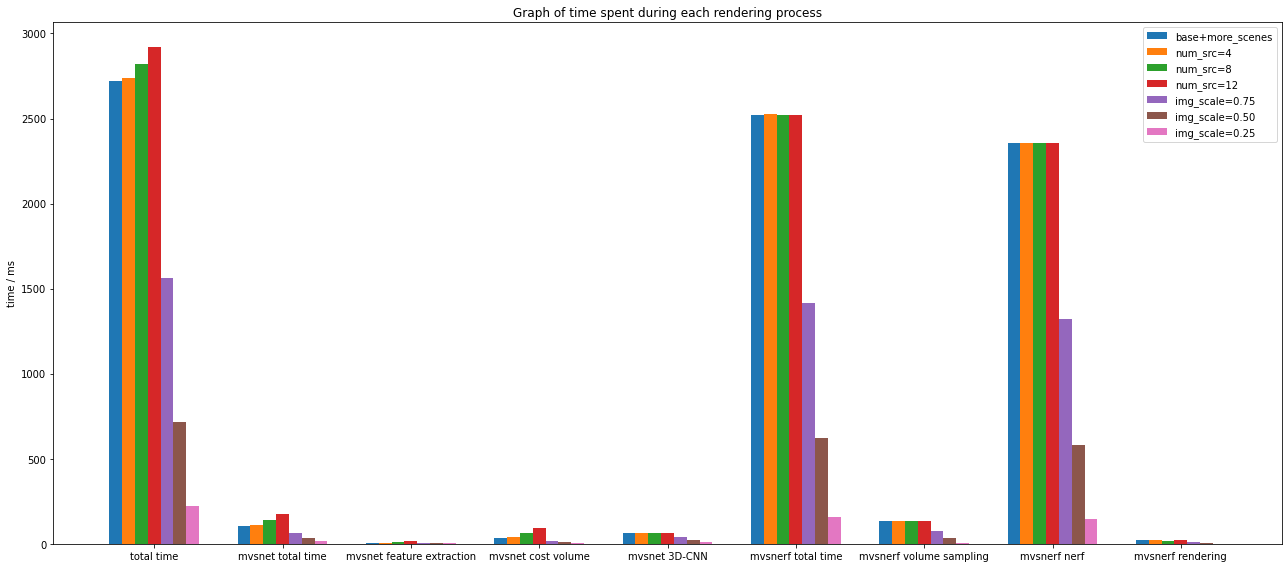

In [45]:
labels = list(records_df.columns.values[7:])
times1 = list(records_df.iloc[0].values[7:])

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width, list(records_df.iloc[1].values[7:]), width, label=records_df.iloc[1].values[0])
rects2 = ax.bar(x - 2*width, list(records_df.iloc[2].values[7:]), width, label=records_df.iloc[2].values[0])
rects3 = ax.bar(x - 1*width, list(records_df.iloc[3].values[7:]), width, label=records_df.iloc[3].values[0])
rects4 = ax.bar(x, list(records_df.iloc[4].values[7:]), width, label=records_df.iloc[4].values[0])
rects5 = ax.bar(x + 1*width, list(records_df.iloc[5].values[7:]), width, label=records_df.iloc[5].values[0])
rects6 = ax.bar(x + 2*width, list(records_df.iloc[6].values[7:]), width, label=records_df.iloc[6].values[0])
rects7 = ax.bar(x + 3*width, list(records_df.iloc[7].values[7:]), width, label=records_df.iloc[7].values[0])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time / ms')
ax.set_title('Graph of time spent during each rendering process')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.rcParams["figure.figsize"] = (18,8)

plt.show()

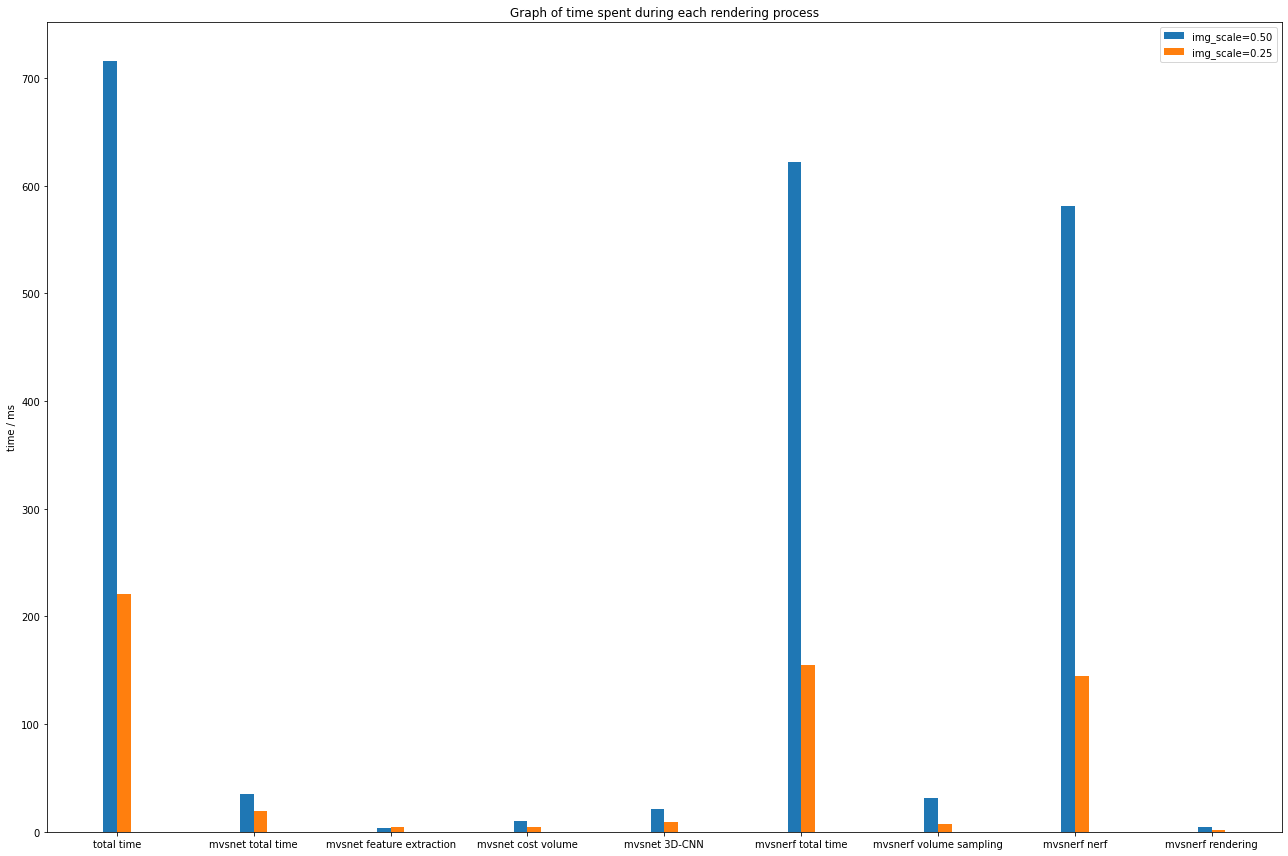

In [49]:
labels = list(records_df.columns.values[7:])
times1 = list(records_df.iloc[0].values[7:])

x = np.arange(len(labels))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects6 = ax.bar(x - 0.5*width, list(records_df.iloc[6].values[7:]), width, label=records_df.iloc[6].values[0])
rects7 = ax.bar(x + 0.5*width, list(records_df.iloc[7].values[7:]), width, label=records_df.iloc[7].values[0])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('time / ms')
ax.set_title('Graph of time spent during each rendering process')
ax.set_xticks(x, labels)
ax.legend()

fig.tight_layout()

plt.rcParams["figure.figsize"] = (5,12)

plt.show()

In [22]:
pairs = torch.load('./configs/pairs.th')

In [23]:
pairs

{'horns_train': array([23, 32, 24, 41, 34, 22, 25, 35, 42, 12, 21, 51, 13, 39, 50, 26]),
 'horns_test': array([33, 40, 31, 59]),
 'horns_val': array([33, 40, 31, 59]),
 'leaves_train': array([12, 18,  8, 17, 14,  7,  3, 22,  2, 19, 23,  9, 10,  6, 15, 21]),
 'leaves_test': array([13, 11, 16,  4]),
 'leaves_val': array([13, 11, 16,  4]),
 'room_train': array([14, 39, 34, 13, 20, 36, 30, 31,  8,  7, 33, 25, 12, 29, 40, 19]),
 'room_test': array([35, 15, 38, 21]),
 'room_val': array([35, 15, 38, 21]),
 'fortress_train': array([15, 20, 26, 14, 22, 27, 33, 39, 16, 32, 19,  8, 10,  3, 13, 28]),
 'fortress_test': array([21,  9, 40, 25]),
 'fortress_val': array([21,  9, 40, 25]),
 'trex_train': array([52, 19, 47, 12, 46, 28, 18, 51, 27, 13, 48, 43, 29, 11, 45, 42]),
 'trex_test': array([20, 21, 53, 22]),
 'trex_val': array([20, 21, 53, 22]),
 'orchids_train': array([ 8, 13, 11, 17,  7,  9, 14, 18, 23,  6,  2, 15,  5,  3, 22, 24]),
 'orchids_test': array([12, 10, 16, 19]),
 'orchids_val': array

In [ ]:
# number of source views 
records_processed = experiment_and_record(records_processed, name='num_src=4', scenes=[1,8,21,30,31,34,63,82,103,114], num_src=4, img_scale=1.0, save_as_image=True)
records_processed = experiment_and_record(records_processed, name='num_src=8', scenes=[1,8,21,30,31,34,63,82,103,114], num_src=8, img_scale=1.0, save_as_image=True)
records_processed = experiment_and_record(records_processed, name='num_src=12', scenes=[1,8,21,30,31,34,63,82,103,114], num_src=12, img_scale=1.0, save_as_image=True)

In [ ]:
# decreasing image scale
records_processed = experiment_and_record(records_processed, name='img_scale=0.8', scenes=[1,8,21,30,31,34,63,82,103,114], num_src=3, img_scale=0.8, save_as_image=True)
records_processed = experiment_and_record(records_processed, name='img_scale=0.6', scenes=[1,8,21,30,31,34,63,82,103,114], num_src=3, img_scale=0.6, save_as_image=True)
records_processed = experiment_and_record(records_processed, name='img_scale=0.4', scenes=[1,8,21,30,31,34,63,82,103,114], num_src=3, img_scale=0.4, save_as_image=True)

# Base code

In [15]:
psnr_all,ssim_all,LPIPS_vgg_all = [],[],[]
depth_acc = {}
eval_metric = [0.1,0.05,0.01]
depth_acc[f'abs_err'],depth_acc[f'acc_l_{eval_metric[0]}'],depth_acc[f'acc_l_{eval_metric[1]}'],depth_acc[f'acc_l_{eval_metric[2]}'] = {},{},{},{}
   

for i_scene, scene in enumerate([1]):#,8,21,103,114

    # create timing variables

    # measure time - all processes
    start_all = torch.cuda.Event(enable_timing=True)
    end_all = torch.cuda.Event(enable_timing=True)

    # measure time - Feature extraction and neural volume encoding
    start_mvsnet = torch.cuda.Event(enable_timing=True)
    end_mvsnet = torch.cuda.Event(enable_timing=True)
    
    # measure time - MVSNeRF and volume rendering
    start_mvsnerf = torch.cuda.Event(enable_timing=True)
    end_mvsnerf = torch.cuda.Event(enable_timing=True)
    
    # measure time - MVSNeRF and volume rendering loop
    start_loop = torch.cuda.Event(enable_timing=True)
    end_loop = torch.cuda.Event(enable_timing=True)

    # measure time - MVSNeRF and volume rendering all loops
    start_loops = torch.cuda.Event(enable_timing=True)
    end_loops = torch.cuda.Event(enable_timing=True)
    
    # for combining all recorded time
    records = []
    records_general = {"0_all" : [], "1_loop" : [], "2_loops" : []}
    records_mvsnet = {"0_total" : [], "1_feat" : [], "2_costvol" : [], "3_3dcnn" : []}
    records_mvsnerf = {"0_total" : [],"1_sample" : [], "2_nerf" : [], "3_rend" : []}
    
    psnr,ssim,LPIPS_vgg = [],[],[]
    cmd = f'--datadir /mnt/hdd/mvsnerf_data/dtu/scan{scene}  \
     --dataset_name dtu_ft  \
     --net_type v0 --ckpt ./ckpts/mvsnerf-v0.tar \
     --imgScale_train 1 --imgScale_test 1 --img_downscale 1'

    args = config_parser(cmd.split())
    args.use_viewdirs = True

    args.N_samples = 128
    args.feat_dim =  8+4*3

    # create models
    if 0==i_scene:
        render_kwargs_train, render_kwargs_test, start, grad_vars = create_nerf_mvs(args, use_mvs=True, dir_embedder=False, pts_embedder=True)
        filter_keys(render_kwargs_train)

        MVSNet = render_kwargs_train['network_mvs']
        render_kwargs_train.pop('network_mvs')


    datadir = args.datadir
    datatype = 'train'
    pad = 16
    args.chunk = 5120


    print('============> rendering dataset <===================')
    dataset_train = dataset_dict[args.dataset_name](args, split='train')
    dataset_val = dataset_dict[args.dataset_name](args, split='val')
    val_idx = dataset_val.img_idx

    save_as_image = True
    save_dir = f'results/test_dtu'
    os.makedirs(save_dir, exist_ok=True)
    MVSNet.train()
    MVSNet = MVSNet.cuda()

    with torch.no_grad():

        try:
            tqdm._instances.clear() 
        except Exception:     
            pass       

        for i, batch in enumerate(tqdm(dataset_val)):
                        
            torch.cuda.empty_cache()
            
            ##################
            # time everything
            ##################
            start_all.record()
            #

            rays, img = decode_batch(batch)
            rays = rays.squeeze().to(device)  # (H*W, 3)
            img = img.squeeze().cpu().numpy()  # (H, W, 3)
            depth = batch['depth'].squeeze().numpy()  # (H, W)

            # find nearest image idx from training views
            positions = dataset_train.poses[:,:3,3]
            dis = np.sum(np.abs(positions - dataset_val.poses[[i],:3,3]), axis=-1)
            pair_idx = np.argsort(dis)[:3]
            pair_idx = [dataset_train.img_idx[item] for item in pair_idx]

            imgs_source, proj_mats, near_far_source, pose_source = dataset_train.read_source_views(pair_idx=pair_idx,device=device)
            
            ##################
            # time mvsnet 0
            ##################
            start_mvsnet.record()
            #
            volume_feature, _, _, records_mvsnet = MVSNet(imgs_source, proj_mats, near_far_source, records=records_mvsnet, pad=pad)
            #
            end_mvsnet.record()
            torch.cuda.synchronize()
            records_mvsnet['0_total'].append(start_mvsnet.elapsed_time(end_mvsnet))
            ##############################################################
            
                
            imgs_source = unpreprocess(imgs_source)

            N_rays_all = rays.shape[0]
            rgb_rays, depth_rays_preds = [],[]
            
            ##################
            # time loops
            ##################
            start_loops.record()
            #
            
            for chunk_idx in range(N_rays_all//args.chunk + int(N_rays_all%args.chunk>0)):
                
                # for loop timing
                ##################
                # time loop
                ##################
                start_loop.record()
                #
                xyz_coarse_sampled, rays_o, rays_d, z_vals = ray_marcher(rays[chunk_idx*args.chunk:(chunk_idx+1)*args.chunk],
                                                    N_samples=args.N_samples)

                # Converting world coordinate to ndc coordinate
                H, W = img.shape[:2]
                inv_scale = torch.tensor([W - 1, H - 1]).to(device)
                w2c_ref, intrinsic_ref = pose_source['w2cs'][0], pose_source['intrinsics'][0].clone()
                xyz_NDC = get_ndc_coordinate(w2c_ref, intrinsic_ref, xyz_coarse_sampled, inv_scale,
                                             near=near_far_source[0], far=near_far_source[1], pad=pad*args.imgScale_test)


                # rendering
                
                ##################
                # time mvsnerf 0
                ##################
                start_mvsnerf.record()
                #
                rgb, disp, acc, depth_pred, alpha, extras, records_mvsnerf = rendering(args, pose_source, xyz_coarse_sampled,
                                                                       xyz_NDC, z_vals, rays_o, rays_d, records_mvsnerf,
                                                                       volume_feature,imgs_source, **render_kwargs_train)
                #
                end_mvsnerf.record()
                torch.cuda.synchronize()
                records_mvsnerf['0_total'].append(start_mvsnerf.elapsed_time(end_mvsnerf))
                ##############################################################
                
                

                rgb, depth_pred = torch.clamp(rgb.cpu(),0,1.0).numpy(), depth_pred.cpu().numpy()
                rgb_rays.append(rgb)
                depth_rays_preds.append(depth_pred)
                
                #
                end_loop.record()
                torch.cuda.synchronize()
                records_general['1_loop'].append(start_loop.elapsed_time(end_loop))
                ##############################################################
            
            #
            end_loops.record()
            torch.cuda.synchronize()
            records_general['2_loops'].append(start_loops.elapsed_time(end_loops))
            ##############################################################
            
            #
            end_all.record()
            torch.cuda.synchronize()
            records_general['0_all'].append(start_all.elapsed_time(end_all))
            ##############################################################
            
            
            depth_rays_preds = np.concatenate(depth_rays_preds).reshape(H, W)

            depth_gt, _ =  read_depth(f'/mnt/hdd/mvsnerf_data/dtu/Depths/scan{scene}/depth_map_{val_idx[i]:04d}.pfm')

            # commented out because prediction and gt shape mismatch
#             mask_gt = depth_gt>0
#             abs_err = abs_error(depth_rays_preds, depth_gt/200, mask_gt)

#             eval_metric = [0.01,0.05, 0.1]
#             depth_acc[f'abs_err'][f'{scene}'] = np.mean(abs_err)
#             depth_acc[f'acc_l_{eval_metric[0]}'][f'{scene}'] = acc_threshold(abs_err,eval_metric[0]).mean()
#             depth_acc[f'acc_l_{eval_metric[1]}'][f'{scene}'] = acc_threshold(abs_err,eval_metric[1]).mean()
#             depth_acc[f'acc_l_{eval_metric[2]}'][f'{scene}'] = acc_threshold(abs_err,eval_metric[2]).mean()


            depth_rays_preds, _ = visualize_depth_numpy(depth_rays_preds, near_far_source)

            rgb_rays = np.concatenate(rgb_rays).reshape(H, W, 3)
            img_vis = np.concatenate((img*255,rgb_rays*255,depth_rays_preds),axis=1)
            
            print(rgb_rays.shape)

            if save_as_image:
                imageio.imwrite(f'{save_dir}/scan{scene}_{val_idx[i]:03d}.png', img_vis.astype('uint8'))
            else:
                rgbs.append(img_vis.astype('uint8'))

            # quantity
            # mask background since they are outside the far boundle
            mask = depth==0
            imageio.imwrite(f'{save_dir}/scan{scene}_{val_idx[i]:03d}_mask.png', mask.astype('uint8')*255)
            rgb_rays[mask],img[mask] = 0.0,0.0
            psnr.append( mse2psnr(np.mean((rgb_rays[~mask]-img[~mask])**2)))
            ssim.append( structural_similarity(rgb_rays, img, multichannel=True))

            img_tensor = torch.from_numpy(rgb_rays)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
            img_gt_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0
            LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())

        print(f'=====> scene: {scene} mean psnr {np.mean(psnr)} ssim: {np.mean(ssim)} lpips: {np.mean(LPIPS_vgg)}')   
        psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)


    if not save_as_image:
        imageio.mimwrite(f'{save_dir}/{scene}_spiral.mp4', np.stack(rgbs), fps=20, quality=10)

# a = np.mean(list(depth_acc['abs_err'].values()))
# b = np.mean(list(depth_acc[f'acc_l_{eval_metric[0]}'].values()))
# c = np.mean(list(depth_acc[f'acc_l_{eval_metric[1]}'].values()))
# d = np.mean(list(depth_acc[f'acc_l_{eval_metric[2]}'].values()))
# print(f'============> abs_err: {a} <=================')
# print(f'============> acc_l_{eval_metric[0]}: {b} <=================')
# print(f'============> acc_l_{eval_metric[1]}: {c} <=================')
# print(f'============> acc_l_{eval_metric[2]}: {d} <=================')
print(f'=====> all mean psnr {np.mean(psnr_all)} ssim: {np.mean(ssim_all)} lpips: {np.mean(LPIPS_vgg_all)}') 

Found ckpts ['./ckpts/mvsnerf-v0.tar']
Reloading from ./ckpts/mvsnerf-v0.tar
============> rendering dataset <===================
==> image down scale: 1.0
===> training index: [25, 21, 33, 22, 14, 15, 26, 30, 31, 35, 34, 43, 46, 29, 16, 36]
==> image down scale: 1.0
===> valing index: [32, 24, 23, 44]


  0%|                                                           | 0/4 [00:00<?, ?it/s]

(512, 640, 3)


  0%|                                                           | 0/4 [00:03<?, ?it/s]


KeyboardInterrupt: 

## rendering novel views with fixed 3 source views

In [ ]:
psnr_all,ssim_all,LPIPS_vgg_all = [],[],[]
for i_scene, scene in enumerate([1,8,21,103,114]):#,
    psnr,ssim,LPIPS_vgg = [],[],[]
    cmd = f'--datadir /mnt/data/new_disk/sungx/data/mvs_dataset/DTU/mvs_training/dtu/scan{scene}  \
    --dataset_name dtu_ft  \
    --ckpt ./ckpts//mvsnerf-v0.tar'

    args = config_parser(cmd.split())
    args.use_viewdirs = True

    args.N_samples = 128
    args.feat_dim =  8+3*4

    # create models
    if 0==i_scene:
        render_kwargs_train, render_kwargs_test, start, grad_vars = create_nerf_mvs(args, use_mvs=True, dir_embedder=False, pts_embedder=True)
        filter_keys(render_kwargs_train)

        MVSNet = render_kwargs_train['network_mvs']
        render_kwargs_train.pop('network_mvs')


    datadir = args.datadir
    datatype = 'val'
    pad = 24
    args.chunk = 5120


    print('============> rendering dataset <===================')
    dataset = dataset_dict[args.dataset_name](args, split=datatype)
    val_idx = dataset.img_idx
    
    save_as_image = True
    save_dir = f'results/test3'
    os.makedirs(save_dir, exist_ok=True)
    MVSNet.train()
    MVSNet = MVSNet.cuda()
    
    with torch.no_grad():

        imgs_source, proj_mats, near_far_source, pose_source = dataset.read_source_views(device=device)
        volume_feature, _, _ = MVSNet(imgs_source, proj_mats, near_far_source, pad=pad)
        imgs_source = unpreprocess(imgs_source)

        try:
            tqdm._instances.clear() 
        except Exception:     
            pass
        
        for i, batch in enumerate(tqdm(dataset)):
            torch.cuda.empty_cache()
            
            rays, img = decode_batch(batch)
            rays = rays.squeeze().to(device)  # (H*W, 3)
            img = img.squeeze().cpu().numpy()  # (H, W, 3)
            depth = batch['depth'].squeeze().numpy()  # (H, W)
        
            N_rays_all = rays.shape[0]
            rgb_rays, depth_rays_preds = [],[]
            for chunk_idx in range(N_rays_all//args.chunk + int(N_rays_all%args.chunk>0)):

                xyz_coarse_sampled, rays_o, rays_d, z_vals = ray_marcher(rays[chunk_idx*args.chunk:(chunk_idx+1)*args.chunk],
                                                    N_samples=args.N_samples)

                # Converting world coordinate to ndc coordinate
                H, W = img.shape[:2]
                inv_scale = torch.tensor([W - 1, H - 1]).to(device)
                w2c_ref, intrinsic_ref = pose_source['w2cs'][0], pose_source['intrinsics'][0].clone()
                xyz_NDC = get_ndc_coordinate(w2c_ref, intrinsic_ref, xyz_coarse_sampled, inv_scale,
                                             near=near_far_source[0], far=near_far_source[1], pad=pad*args.imgScale_test)


                # rendering
                rgb, disp, acc, depth_pred, alpha, extras = rendering(args, pose_source, xyz_coarse_sampled,
                                                                       xyz_NDC, z_vals, rays_o, rays_d,
                                                                       volume_feature,imgs_source, **render_kwargs_train)
    
                
                rgb, depth_pred = torch.clamp(rgb.cpu(),0,1.0).numpy(), depth_pred.cpu().numpy()
                rgb_rays.append(rgb)
                depth_rays_preds.append(depth_pred)

            
            depth_rays_preds = np.concatenate(depth_rays_preds).reshape(H, W)
            depth_rays_preds, _ = visualize_depth_numpy(depth_rays_preds, near_far_source)
            
            rgb_rays = np.concatenate(rgb_rays).reshape(H, W, 3)
            img_vis = np.concatenate((img*255,rgb_rays*255,depth_rays_preds),axis=1)
            
            if save_as_image:
                imageio.imwrite(f'{save_dir}/scan{scene}_{val_idx[i]:03d}.png', img_vis.astype('uint8'))
            else:
                rgbs.append(img_vis.astype('uint8'))
                
            # quantity
            # mask background since they are outside the far boundle
            mask = depth==0
            imageio.imwrite(f'{save_dir}/scan{scene}_{val_idx[i]:03d}_mask.png', mask.astype('uint8')*255)
            rgb_rays[mask],img[mask] = 0.0,0.0
            psnr.append( mse2psnr(np.mean((rgb_rays[~mask]-img[~mask])**2)))
            ssim.append( structural_similarity(rgb_rays, img, multichannel=True))
            
            img_tensor = torch.from_numpy(rgb_rays)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
            img_gt_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0
            LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())

        print(f'=====> scene: {scene} mean psnr {np.mean(psnr)} ssim: {np.mean(ssim)} lpips: {np.mean(LPIPS_vgg)}')   
        psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)

    if not save_as_image:
        imageio.mimwrite(f'{save_dir}/{scene}_spiral.mp4', np.stack(rgbs), fps=20, quality=10)
print(f'=====> all mean psnr {np.mean(psnr_all)} ssim: {np.mean(ssim_all)} lpips: {np.mean(LPIPS_vgg_all)}') 

# Pairs generation

In [3]:
import json,torch
import sys,os
import numpy as np
root = '/home/hengfei/Desktop/research/mvsnerf'
os.chdir(root)
sys.path.append(root)
pairs = torch.load('./configs/pairs.th')

# llff
root_dir = '/home/hengfei/Desktop/research/mvsnerf/xgaze/'
for scene in ['xgaze_11images_cropped_colmapCODE']:#
    poses_bounds = np.load(os.path.join(root_dir, scene, 'poses_bounds.npy'))  # (N_images, 11)
    poses = poses_bounds[:, :15].reshape(-1, 3, 5)  # (N_images, 3, 5)
    poses = np.concatenate([poses[..., 1:2], - poses[..., :1], poses[..., 2:4]], -1)

    ref_position = np.mean(poses[..., 3],axis=0, keepdims=True)
    dist = np.sum(np.abs(poses[..., 3] - ref_position), axis=-1)
    pair_idx = np.argsort(dist)[:11]
#     pair_idx = torch.randperm(len(poses))[:20].tolist()

    pairs[f'{scene}_test'] = pair_idx[::6]
    pairs[f'{scene}_val'] = pair_idx[::6]
    pairs[f'{scene}_train'] = np.delete(pair_idx, range(0,11,6))

torch.save(pairs,'/home/hengfei/Desktop/research/mvsnerf/configs/pairs.th')

# nerf 

In [22]:
root = '/mnt/new_disk_2/anpei/code/nerf/logs/'
root_gt = '/mnt/new_disk2/anpei/code/MVS-NeRF/runs_fine_tuning/'
pairs = torch.load('/mnt/new_disk_2/anpei/code/MVS-NeRF/configs/pairs.th')
psnr_all,ssim_all,LPIPS_vgg_all = [],[],[]
for i_scene, scene in enumerate(['chair','drums','ficus','hotdog','lego','materials','mic','ship']):#
    psnr,ssim,LPIPS_vgg = [],[],[]
    
    files = sorted(glob.glob(f'{root}/{scene}_test/testset_200000/*.png'))
    for j, file in enumerate(files):

        idx = pairs[f'{scene}_val'][j]
        img = cv2.imread(file)[...,::-1]
        gt = cv2.imread(f'{root_gt}/{scene}/{scene}/{scene}_00009999_{j:02d}.png')[...,::-1]
        gt, img = gt[:,:800].astype('float')/255.0, img.astype('float')/255.0

#         H_crop, W_crop = np.array(gt.shape[:2])//10
#         img = img[H_crop:-H_crop,W_crop:-W_crop]
#         gt = gt[H_crop:-H_crop,W_crop:-W_crop]

        psnr.append( mse2psnr(np.mean((gt-img)**2)))
        ssim.append( structural_similarity(gt, img, multichannel=True))

        img_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
        img_gt_tensor = torch.from_numpy(gt)[None].permute(0,3,1,2).float()*2-1.0
        LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())

    print(f'=====> scene: {scene} mean psnr {np.mean(psnr)} ssim: {np.mean(ssim)} lpips: {np.mean(LPIPS_vgg)}')   
    psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)
print(f'=====> all mean psnr {np.mean(psnr_all)} ssim: {np.mean(ssim_all)} lpips: {np.mean(LPIPS_vgg_all)}') 

psnr_all,ssim_all,LPIPS_vgg_all = [],[],[]
for i_scene, scene in enumerate(['fern','flower','fortress','horns','leaves', 'orchids', 'room',  'trex']):#,
    psnr,ssim,LPIPS_vgg = [],[],[]
    
    files = sorted(glob.glob(f'{root}/{scene}_test/testset_200000/*.png'))
    for j, file in enumerate(files):

        idx = pairs[f'{scene}_val'][j]
        img = cv2.resize(cv2.imread(file)[...,::-1],(960,640))
        gt =  cv2.imread(f'/mnt/new_disk2/anpei/code/MVS-NeRF/results/test3/{scene}_{idx:03d}.png')[...,::-1]
        gt, img = gt[:,:960].astype('float')/255.0, img.astype('float')/255.0


        psnr.append( mse2psnr(np.mean((gt-img)**2)))
        ssim.append( structural_similarity(gt, img, multichannel=True))

        img_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
        img_gt_tensor = torch.from_numpy(gt)[None].permute(0,3,1,2).float()*2-1.0
        LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())

    print(f'=====> scene: {scene} mean psnr {np.mean(psnr)} ssim: {np.mean(ssim)} lpips: {np.mean(LPIPS_vgg)}')   
    psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)
print(f'=====> all mean psnr {np.mean(psnr_all)} ssim: {np.mean(ssim_all)} lpips: {np.mean(LPIPS_vgg_all)}') 

psnr_all,ssim_all,LPIPS_vgg_all = [],[],[]
for i_scene, scene in enumerate([1,8,21,103,114]):#,
    psnr,ssim,LPIPS_vgg = [],[],[]
    
    files = sorted(glob.glob(f'{root}/scan{scene}_test/testset_200000/*.png'))
    for j, file in enumerate(files):

        idx = pairs[f'dtu_val'][j]
        img = cv2.imread(file)[...,::-1]
        gt = cv2.imread(f'/mnt/new_disk2/anpei/code/MVS-NeRF/results/test3/scan{scene}_{idx:03d}.png')[...,::-1]
        mask = cv2.imread(f'/mnt/new_disk2/anpei/code/MVS-NeRF/results/test3/scan{scene}_{idx:03d}_mask.png')==255
        gt, img = gt[:,:640].astype('float')/255.0, img.astype('float')/255.0

        gt[mask],img[mask] = 0.0,0.0
        psnr.append( mse2psnr(np.mean((gt[~mask]-img[~mask])**2)))
        ssim.append( structural_similarity(gt, img, multichannel=True))

        img_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
        img_gt_tensor = torch.from_numpy(gt)[None].permute(0,3,1,2).float()*2-1.0
        LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())

    print(f'=====> scene: {scene} mean psnr {np.mean(psnr)} ssim: {np.mean(ssim)} lpips: {np.mean(LPIPS_vgg)}')   
    psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)
print(f'=====> all mean psnr {np.mean(psnr_all)} ssim: {np.mean(ssim_all)} lpips: {np.mean(LPIPS_vgg_all)}') 

=====> scene: chair mean psnr 31.070870959993407 ssim: 0.970869913728838 lpips: 0.05512496456503868
=====> scene: drums mean psnr 25.464383523724557 ssim: 0.9430287321705997 lpips: 0.1010842639952898
=====> scene: ficus mean psnr 29.72717081186501 ssim: 0.9688198661712594 lpips: 0.04721927270293236
=====> scene: hotdog mean psnr 34.63162021512352 ssim: 0.9798700143526428 lpips: 0.0885334312915802
=====> scene: lego mean psnr 32.65761069614622 ssim: 0.9751430050524844 lpips: 0.05375238787382841
=====> scene: materials mean psnr 30.220202654922936 ssim: 0.9677394226502894 lpips: 0.1052329633384943
=====> scene: mic mean psnr 31.810551677509977 ssim: 0.9810118386928188 lpips: 0.03268271638080478
=====> scene: ship mean psnr 29.487980342358682 ssim: 0.9079920156014059 lpips: 0.2625834122300148
=====> all mean psnr 30.633798860205538 ssim: 0.9618093510525423 lpips: 0.09327667654724792
=====> scene: fern mean psnr 23.87081932481545 ssim: 0.828319405500272 lpips: 0.29106350988149643
=====> sc

# ours

In [10]:
root = '/mnt/new_disk2/anpei/code/MVS-NeRF/runs_fine_tuning/'
pairs = torch.load('/mnt/new_disk_2/anpei/code/MVS-NeRF/configs/pairs.th')
psnr_all,ssim_all,LPIPS_vgg_all = [],[],[]
for i_scene, scene in enumerate(['chair','drums','ficus','hotdog','lego','materials','mic','ship']):
    psnr,ssim,LPIPS_vgg = [],[],[]
    
    files = sorted(glob.glob(f'{root}/{scene}/{scene}/{scene}_00009999_*'))
    for j, file in enumerate(files):

        idx = pairs[f'{scene}_val'][j]
        img = cv2.imread(file).astype('float')[...,::-1]
        gt, img = img[:,:800]/255.0, img[:,800:1600]/255.0

#         H_crop, W_crop = np.array(gt.shape[:2])//10
#         img = img[H_crop:-H_crop,W_crop:-W_crop]
#         gt = gt[H_crop:-H_crop,W_crop:-W_crop]

        psnr.append( mse2psnr(np.mean((gt-img)**2)))
        ssim.append( structural_similarity(gt, img, multichannel=True))

        img_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
        img_gt_tensor = torch.from_numpy(gt)[None].permute(0,3,1,2).float()*2-1.0
        LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())

    print(f'=====> scene: {scene} mean psnr {np.mean(psnr)} ssim: {np.mean(ssim)} lpips: {np.mean(LPIPS_vgg)}')   
    psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)
print(f'=====> all mean psnr {np.mean(psnr_all)} ssim: {np.mean(ssim_all)} lpips: {np.mean(LPIPS_vgg_all)}') 

psnr_all,ssim_all,LPIPS_vgg_all = [],[],[]
for i_scene, scene in enumerate(['fern','flower','fortress','horns','leaves', 'orchids', 'room',  'trex']):#,
    psnr,ssim,LPIPS_vgg = [],[],[]
    
    files = sorted(glob.glob(f'/mnt/new_disk2/anpei/code/MVS-NeRF/runs_fine_tuning/{scene}/{scene}/{scene}_00009999_*'))
    for j, file in enumerate(files):

        idx = pairs[f'{scene}_val'][j]
        img = cv2.imread(file)[...,::-1]
        gt, img = img[:,:960].astype('float')/255.0, img[:,960:960*2].astype('float')/255.0

        H_crop, W_crop = np.array(gt.shape[:2])//10
        img = img[H_crop:-H_crop,W_crop:-W_crop]
        gt = gt[H_crop:-H_crop,W_crop:-W_crop]


        psnr.append( mse2psnr(np.mean((gt-img)**2)))
        ssim.append( structural_similarity(gt, img, multichannel=True))

        img_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
        img_gt_tensor = torch.from_numpy(gt)[None].permute(0,3,1,2).float()*2-1.0
        LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())

    print(f'=====> scene: {scene} mean psnr {np.mean(psnr)} ssim: {np.mean(ssim)} lpips: {np.mean(LPIPS_vgg)}')   
    psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)
print(f'=====> all mean psnr {np.mean(psnr_all)} ssim: {np.mean(ssim_all)} lpips: {np.mean(LPIPS_vgg_all)}') 

root = '/mnt/new_disk2/anpei/code/MVS-NeRF/runs_fine_tuning/'
psnr_all,ssim_all,LPIPS_vgg_all = [],[],[]
for i_scene, scene in enumerate([1,8,21,103,114]):#,
    psnr,ssim,LPIPS_vgg = [],[],[]
    
    files = sorted(glob.glob(f'{root}/dtu_scan{scene}_1h/dtu_scan{scene}_1h/00010239_*'))
    for j, file in enumerate(files):

        idx = pairs[f'dtu_val'][j]
        img = cv2.imread(file)[...,::-1][:,640:1280]
        gt = cv2.imread(f'/mnt/new_disk2/anpei/code/MVS-NeRF/results/test3/scan{scene}_{idx:03d}.png')[...,::-1]
        mask = cv2.imread(f'/mnt/new_disk2/anpei/code/MVS-NeRF/results/test3/scan{scene}_{idx:03d}_mask.png')==255
        gt, img = gt[:,:640].astype('float')/255.0, img.astype('float')/255.0

        gt[mask],img[mask] = 0.0,0.0
        psnr.append( mse2psnr(np.mean((gt[~mask]-img[~mask])**2)))
        ssim.append( structural_similarity(gt, img, multichannel=True))

        img_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
        img_gt_tensor = torch.from_numpy(gt)[None].permute(0,3,1,2).float()*2-1.0
        LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())

    print(f'=====> scene: {scene} mean psnr {np.mean(psnr)} ssim: {np.mean(ssim)} lpips: {np.mean(LPIPS_vgg)}')   
    psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)
print(f'=====> all mean psnr {np.mean(psnr_all)} ssim: {np.mean(ssim_all)} lpips: {np.mean(LPIPS_vgg_all)}') 

=====> scene: chair mean psnr 26.746873810513947 ssim: 0.9321234340308168 lpips: 0.15475058555603027
=====> scene: drums mean psnr 22.28406117543553 ssim: 0.8964614019632969 lpips: 0.21542910858988762
=====> scene: ficus mean psnr 26.365789669973488 ssim: 0.9438413276712496 lpips: 0.15914445742964745
=====> scene: hotdog mean psnr 32.489636248742805 ssim: 0.9699785599978382 lpips: 0.11295554973185062
=====> scene: lego mean psnr 26.79832336361502 ssim: 0.9245065827858229 lpips: 0.18708691000938416
=====> scene: materials mean psnr 24.957611270986945 ssim: 0.9249186604651752 lpips: 0.1740873008966446
=====> scene: mic mean psnr 29.449610622444368 ssim: 0.9693072200690339 lpips: 0.092950988560915
=====> scene: ship mean psnr 26.60832366062154 ssim: 0.8780999869891254 lpips: 0.28621142730116844
=====> all mean psnr 26.962528727791707 ssim: 0.9299046467465449 lpips: 0.17282704100944102
=====> scene: fern mean psnr 22.61357364768159 ssim: 0.77000724312094 lpips: 0.2827577739953995
=====> sc

# ibrnet

In [6]:
# root = '/mnt/new_disk2/anpei/code/IBRNet/logs'
pairs = torch.load('/mnt/new_disk_2/anpei/code/MVS-NeRF/configs/pairs.th')
# psnr_all,ssim_all,LPIPS_vgg_all = [],[],[]
# for i_scene, scene in enumerate(['chair','drums','ficus','hotdog','lego','materials','mic','ship']):#,
#     psnr,ssim,LPIPS_vgg = [],[],[]
    
#     files = sorted(glob.glob(f'{root}/nerf-3view-finetuning-nearest-{scene}/010000_*'))
#     for j, file in enumerate(files):

#         idx = pairs[f'{scene}_val'][j]
#         img = cv2.imread(file).astype('float')[...,::-1]
#         gt, img = img[:,800:800*2]/255.0, img[:,800*3:800*4]/255.0

# #         H_crop, W_crop = np.array(gt.shape[:2])//10
# #         img = img[H_crop:-H_crop,W_crop:-W_crop]
# #         gt = gt[H_crop:-H_crop,W_crop:-W_crop]

#         psnr.append( mse2psnr(np.mean((gt-img)**2)))
#         ssim.append( structural_similarity(gt, img, multichannel=True))

#         img_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
#         img_gt_tensor = torch.from_numpy(gt)[None].permute(0,3,1,2).float()*2-1.0
#         LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())

#     print(f'=====> scene: {scene} mean psnr {np.mean(psnr)} ssim: {np.mean(ssim)} lpips: {np.mean(LPIPS_vgg)}')   
#     psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)
# print(f'=====> all mean psnr {np.mean(psnr_all)} ssim: {np.mean(ssim_all)} lpips: {np.mean(LPIPS_vgg_all)}') 

psnr_all,ssim_all,LPIPS_vgg_all = [],[],[]
for i_scene, scene in enumerate(['fern','flower','fortress','horns','leaves', 'orchids', 'room',  'trex']):#
    psnr,ssim,LPIPS_vgg = [],[],[]
    
    files = sorted(glob.glob(f'/mnt/new_disk2/anpei/code/IBRNet/logs/llff-3view-finetuning-nearest-{scene}/010000_*'))
    for j, file in enumerate(files):

        idx = pairs[f'{scene}_val'][j]
        img = cv2.imread(file)[...,::-1]
        gt, img = img[:,1008:1008*2].astype('float')/255.0, img[:,1008*3:1008*4].astype('float')/255.0
        img, gt = cv2.resize(img,(960,640)), cv2.resize(gt,(960,640))

        H_crop, W_crop = np.array(gt.shape[:2])//10
        img = img[H_crop:-H_crop,W_crop:-W_crop]
        gt = gt[H_crop:-H_crop,W_crop:-W_crop]

        
        psnr.append( mse2psnr(np.mean((gt-img)**2)))
        ssim.append( structural_similarity(gt, img, multichannel=True))

        img_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
        img_gt_tensor = torch.from_numpy(gt)[None].permute(0,3,1,2).float()*2-1.0
        LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())

    print(f'=====> scene: {scene} mean psnr {np.mean(psnr)} ssim: {np.mean(ssim)} lpips: {np.mean(LPIPS_vgg)}')   
    psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)
print(f'=====> all mean psnr {np.mean(psnr_all)} ssim: {np.mean(ssim_all)} lpips: {np.mean(LPIPS_vgg_all)}') 

root = '/mnt/new_disk2/anpei/code/IBRNet/logs'
psnr_all,ssim_all,LPIPS_vgg_all = [],[],[]
for i_scene, scene in enumerate([1,8,21,103,114]):#
    psnr,ssim,LPIPS_vgg = [],[],[]
    
    files = sorted(glob.glob(f'{root}/dtu-3view-finetuning-nearest-scan{scene}/010000_*'))
    for j, file in enumerate(files):

        idx = pairs[f'dtu_val'][j]
        img = cv2.imread(file)[...,::-1][:,3*640:4*640]
        gt = cv2.imread(f'/mnt/new_disk2/anpei/code/MVS-NeRF/results/test3/scan{scene}_{idx:03d}.png')[...,::-1]
        mask = cv2.imread(f'/mnt/new_disk2/anpei/code/MVS-NeRF/results/test3/scan{scene}_{idx:03d}_mask.png')==255
        gt, img = gt[:,:640].astype('float')/255.0, img.astype('float')/255.0

        gt[mask],img[mask] = 0.0,0.0
        psnr.append( mse2psnr(np.mean((gt[~mask]-img[~mask])**2)))
        ssim.append( structural_similarity(gt, img, multichannel=True))

        img_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
        img_gt_tensor = torch.from_numpy(gt)[None].permute(0,3,1,2).float()*2-1.0
        LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())

    print(f'=====> scene: {scene} mean psnr {np.mean(psnr)} ssim: {np.mean(ssim)} lpips: {np.mean(LPIPS_vgg)}')   
    psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)
print(f'=====> all mean psnr {np.mean(psnr_all)} ssim: {np.mean(ssim_all)} lpips: {np.mean(LPIPS_vgg_all)}') 

=====> scene: fern mean psnr 22.64474646040451 ssim: 0.7736232480476191 lpips: 0.26588304713368416
=====> scene: flower mean psnr 26.553349019087786 ssim: 0.9092690161984827 lpips: 0.14575103670358658
=====> scene: fortress mean psnr 30.338842953903075 ssim: 0.9368867837660259 lpips: 0.13289865292608738
=====> scene: horns mean psnr 25.01290939681414 ssim: 0.9040335882553917 lpips: 0.1899307444691658
=====> scene: leaves mean psnr 22.076508076698556 ssim: 0.8430354849586478 lpips: 0.17987846583127975
=====> scene: orchids mean psnr 19.007830032899616 ssim: 0.7045611776629173 lpips: 0.2861044891178608
=====> scene: room mean psnr 31.05473820815669 ssim: 0.9723299877991765 lpips: 0.08911459799855947
=====> scene: trex mean psnr 22.339864946223464 ssim: 0.8421255627008343 lpips: 0.22207806631922722
=====> all mean psnr 24.878598636773482 ssim: 0.8607331061736369 lpips: 0.1889548875624314
=====> scene: 1 mean psnr 30.99564992655386 ssim: 0.9548394719193786 lpips: 0.1285402663052082
=====> 

# pixel nerf

In [6]:
root = '/mnt/new_disk2/anpei/code/pixel-nerf/visuals/dtu'
root_gt = '/mnt/new_disk2/anpei/code/MVS-NeRF/runs_fine_tuning/'
pairs = torch.load('/mnt/new_disk_2/anpei/code/MVS-NeRF/configs/pairs.th')
psnr_all,ssim_all,LPIPS_vgg_all = [],[],[]
for i_scene, scene in enumerate(['chair','drums','ficus','hotdog','lego','materials','mic','ship']):#,
    psnr,ssim,LPIPS_vgg = [],[],[]
    
    pairs_idx = pairs[f'{scene}_val']
    for j, file in enumerate(pairs_idx):

        idx = pairs_idx[j]
        img = cv2.imread(f'{root}/{scene}_{idx:03d}.png')[...,::-1]
        gt = cv2.imread(f'{root_gt}/{scene}/{scene}/{scene}_00009999_{j:02d}.png')[...,::-1]
        gt, img = gt[:,:800].astype('float')/255.0, img.astype('float')/255.0

#         H_crop, W_crop = np.array(gt.shape[:2])//10
#         img = img[H_crop:-H_crop,W_crop:-W_crop]
#         gt = gt[H_crop:-H_crop,W_crop:-W_crop]

        psnr.append( mse2psnr(np.mean((gt-img)**2)))
        ssim.append( structural_similarity(gt, img, multichannel=True))

        img_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
        img_gt_tensor = torch.from_numpy(gt)[None].permute(0,3,1,2).float()*2-1.0
        LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())

    print(f'=====> scene: {scene} mean psnr {np.mean(psnr)} ssim: {np.mean(ssim)} lpips: {np.mean(LPIPS_vgg)}')   
    psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)
print(f'=====> all mean psnr {np.mean(psnr_all)} ssim: {np.mean(ssim_all)} lpips: {np.mean(LPIPS_vgg_all)}') 

psnr_all,ssim_all,LPIPS_vgg_all = [],[],[]
for i_scene, scene in enumerate(['fern','flower','fortress','horns','leaves', 'orchids', 'room',  'trex']):#,
    psnr,ssim,LPIPS_vgg = [],[],[]
    
    pairs_idx = pairs[f'{scene}_val']
    for j, file in enumerate(pairs_idx):

        idx = pairs_idx[j]
        img = cv2.resize(cv2.imread(f'{root}/{scene}_{idx:03d}.png')[...,::-1],(960,640))
        gt =  cv2.imread(f'/mnt/new_disk2/anpei/code/MVS-NeRF/results/test3/{scene}_{idx:03d}.png')[...,::-1]
        gt, img = gt[:,:960].astype('float')/255.0, img.astype('float')/255.0


        psnr.append( mse2psnr(np.mean((gt-img)**2)))
        ssim.append( structural_similarity(gt, img, multichannel=True))

        img_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
        img_gt_tensor = torch.from_numpy(gt)[None].permute(0,3,1,2).float()*2-1.0
        LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())

    print(f'=====> scene: {scene} mean psnr {np.mean(psnr)} ssim: {np.mean(ssim)} lpips: {np.mean(LPIPS_vgg)}')   
    psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)
print(f'=====> all mean psnr {np.mean(psnr_all)} ssim: {np.mean(ssim_all)} lpips: {np.mean(LPIPS_vgg_all)}') 

psnr_all,ssim_all,LPIPS_vgg_all,depth_acc = [],[],[],[]
for i_scene, scene in enumerate([1,8,21,103,114]):#,
    psnr,ssim,LPIPS_vgg = [],[],[]
    
    pairs_idx = pairs[f'dtu_val']
    for j, file in enumerate(pairs_idx):

        idx = pairs_idx[j]
        img = cv2.imread(f'{root}/scan{scene}_{idx:03d}.png')[...,::-1]
        
        gt = cv2.imread(f'/mnt/new_disk2/anpei/code/MVS-NeRF/results/test3/scan{scene}_{idx:03d}.png')[...,::-1]
        mask = cv2.imread(f'/mnt/new_disk2/anpei/code/MVS-NeRF/results/test3/scan{scene}_{idx:03d}_mask.png')==255
        gt, img = gt[:,:640].astype('float')/255.0, img.astype('float')/255.0

        gt[mask],img[mask] = 0.0,0.0
        psnr.append( mse2psnr(np.mean((gt[~mask]-img[~mask])**2)))
        ssim.append( structural_similarity(gt, img, multichannel=True))

        img_tensor = torch.from_numpy(img)[None].permute(0,3,1,2).float()*2-1.0 # image should be RGB, IMPORTANT: normalized to [-1,1]
        img_gt_tensor = torch.from_numpy(gt)[None].permute(0,3,1,2).float()*2-1.0
        LPIPS_vgg.append( loss_fn_vgg(img_tensor, img_gt_tensor).item())
        
        # depth
#         depth_pred = torch.load(f'{root}/scan{scene}_{idx:03d}_depth.th')
#         depth_gt,_ =  read_depth(f'/mnt/data/new_disk/sungx/data/mvs_dataset/DTU/mvs_training/dtu/Depths/scan{scene}/depth_map_{idx:04d}.pfm')
        
#         mask_gt = depth_gt>0
#         abs_err = abs_error(depth_pred*1.5, depth_gt/200, mask_gt).numpy()

#         eval_metric = [0.01,0.05, 0.1]
#         depth_acc[f'abs_err'][f'{scene}'] = np.mean(abs_err)
#         depth_acc[f'acc_l_{eval_metric[0]}'][f'{scene}'] = acc_threshold(abs_err,eval_metric[0]).mean()
#         depth_acc[f'acc_l_{eval_metric[1]}'][f'{scene}'] = acc_threshold(abs_err,eval_metric[1]).mean()
#         depth_acc[f'acc_l_{eval_metric[2]}'][f'{scene}'] = acc_threshold(abs_err,eval_metric[2]).mean()

    print(f'=====> scene: {scene} mean psnr {np.mean(psnr)} ssim: {np.mean(ssim)} lpips: {np.mean(LPIPS_vgg)}')   
    psnr_all.append(psnr);ssim_all.append(ssim);LPIPS_vgg_all.append(LPIPS_vgg)
print(f'=====> all mean psnr {np.mean(psnr_all)} ssim: {np.mean(ssim_all)} lpips: {np.mean(LPIPS_vgg_all)}') 

=====> scene: chair mean psnr 7.175962813343725 ssim: 0.6243642351905847 lpips: 0.38591109961271286
=====> scene: drums mean psnr 8.148548711878252 ssim: 0.6701584468514097 lpips: 0.42121122032403946
=====> scene: ficus mean psnr 6.608732738834844 ssim: 0.668716265099144 lpips: 0.3350602239370346
=====> scene: hotdog mean psnr 6.799387670799135 ssim: 0.6689815218041557 lpips: 0.43327029794454575
=====> scene: lego mean psnr 7.740217521658803 ssim: 0.6710903029993184 lpips: 0.42670799791812897
=====> scene: materials mean psnr 7.609290420358684 ssim: 0.6441046576733512 lpips: 0.43245941400527954
=====> scene: mic mean psnr 7.707203698223274 ssim: 0.7294597852809476 lpips: 0.32929887622594833
=====> scene: ship mean psnr 7.295484760785579 ssim: 0.5836685948507447 lpips: 0.5257005095481873
=====> all mean psnr 7.385603541985287 ssim: 0.657567976218707 lpips: 0.4112024549394846
=====> scene: fern mean psnr 12.397648684821284 ssim: 0.5312397318110376 lpips: 0.6500117480754852
=====> scene: 